<a href="https://colab.research.google.com/github/lakshchikara/Generative-AI/blob/main/Task_5_Intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 0, Total Loss: 517430720.0
Step 50, Total Loss: 337536768.0
Step 100, Total Loss: 285294048.0
Step 150, Total Loss: 239220448.0
Step 200, Total Loss: 191684576.0
Step 250, Total Loss: 147013952.0


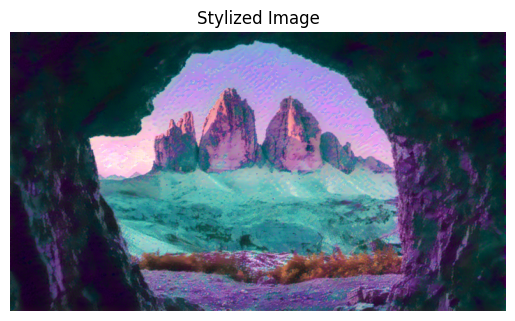

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def load_image(path, max_size=400):
    image = Image.open(path).convert('RGB')
    size = max(image.size) if max(image.size) < max_size else max_size

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = in_transform(image).unsqueeze(0)
    return image.to(device)

# Upload images (use left panel in Colab: Files > Upload)
content = load_image("content.jpg")  # rename your content image
style = load_image("style.jpg")      # rename your style image

vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze all VGG parameters
for param in vgg.parameters():
    param.requires_grad = False

def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # content layer
            '28': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create target image (copy of content)
target = content.clone().requires_grad_(True).to(device)

# Loss weights
style_weight = 1e6
content_weight = 1

optimizer = optim.Adam([target], lr=0.003)

for step in range(300):
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    style_loss = 0
    for layer in style_grams:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_loss = torch.mean((target_gram - style_gram) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_loss / (c * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Total Loss: {total_loss.item()}")

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = image.numpy().transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # de-normalize
    image = image.clip(0, 1)
    return image

plt.imshow(im_convert(target))
plt.axis("off")
plt.title("Stylized Image")
plt.show()

from PIL import Image
output_image = im_convert(target)
Image.fromarray((output_image * 255).astype('uint8')).save("stylized_output.jpg")

from google.colab import files
files.download("stylized_output.jpg")
